In [1]:
import mbuild as mb
import numpy as np
import matplotlib.pyplot as plt

from diffractometer import Diffractometer

/Users/jennyfothergill/miniconda3/envs/cme_utils/lib/python3.8/site-packages/hoomd/meta.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
## Used for creating files to get diffraction data

#pdbname = "fcc10"
#pdbname = "bcc10"
pdbname = "sc10"

dirname = "diffract_data"

box = mb.Box(np.array([10,10,10])/10) # mbuild scales pdbs... 
#print(box)
pdb = mb.load(f"{dirname}/{pdbname}.pdb")
#pdb.visualize().show()
#print([i for i in pdb.particles()])
#pdb.save(f"{dirname}/{pdbname}.gsd", box=box, overwrite=True)

In [3]:
box = mb.Box(np.array([10,10,10])/10) # mbuild scales pdbs... 
#print(box)
pdb = mb.load(f"{dirname}/{pdbname}.pdb")

In [4]:
pdb.visualize().show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
d = Diffractometer()

In [6]:
d.load(pdb.xyz, box.maxs)

In [7]:
# d.load sets the following

#print(d.box)
#for i in range(d.orig.shape[0]):
#    print(d.orig[i,:], d.image[i,:])

In [8]:
from cme_utils.manip import utilities
n_v = 20
def prep_matrices():
    ga = np.pi * (3.0 - 5 ** 0.5)
    theta = ga * np.arange(n_v - 3)
    z = np.linspace(
        1 - 1.0 / (n_v - 3), 1.0 / (n_v - 1 - 3), n_v - 3
    )
    radius = np.sqrt(1.0 - z * z)
    points = np.zeros((n_v, 3))
    points[:-3, 0] = radius * np.cos(theta)
    points[:-3, 1] = radius * np.sin(theta)
    points[:-3, 2] = z
    points[-3] = np.array([0, 0, 1])
    points[-2] = np.array([0, 1, 1])
    points[-1] = np.array([1, 1, 1])
    return [utilities.rotation_matrix_from_to(i, np.array([0, 0, 1])) for i in points]

rotmats = prep_matrices()

In [9]:
#for i,mat in enumerate(rotmats):
#    print(i)
#    print(mat)

In [10]:
from scipy import interpolate, ndimage

rot = rotmats[0]
print(rot.shape)
N = d.N / d.zoom
inv_shear = d.calc_proj(rot)
print(inv_shear.shape)
xy = np.copy(np.dot(d.orig, rot)[:, 0:2])
print(xy.shape)
xy = np.dot(xy, inv_shear.T)
print(xy.shape)
xy = d.pbc_2d(xy, N)
print(xy.shape)
im = d.bin(xy, N)
print(im.shape)

dp = np.fft.fft2(im)
print(dp.shape)
dp = ndimage.fourier.fourier_gaussian(dp, d.peak_width / d.zoom)
dp = np.fft.fftshift(dp)
dp = np.absolute(dp)
dp *= dp
dp = d.scale(dp)
print(dp.shape)
dp = d.shear_back(dp, inv_shear)
print(dp.shape)
dp /= dp.max()
dp[dp < d.bot] = d.bot

(3, 3)
(2, 2)
(1331, 2)
(1331, 2)
(1331, 2)
(128, 128)
(128, 128)
(512, 512)
(512, 512)


(57875,)


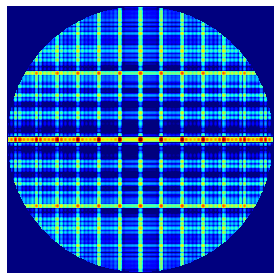

(57875,)


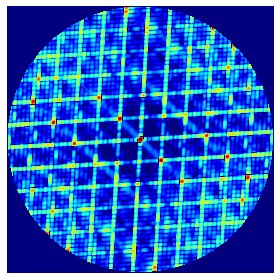

(57875,)


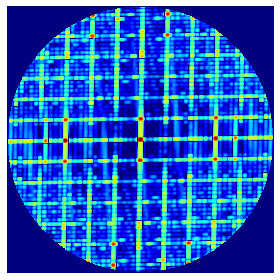

(57875,)


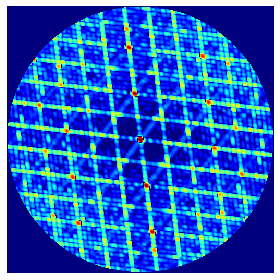

(57875,)


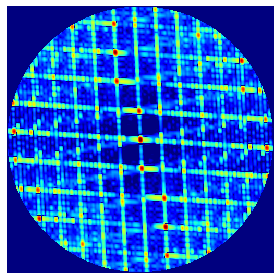

(57875,)


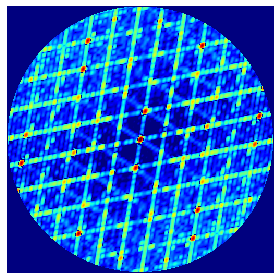

(57875,)


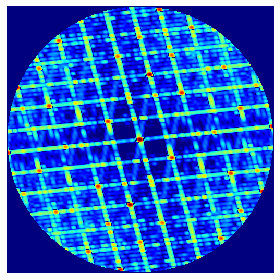

(57875,)


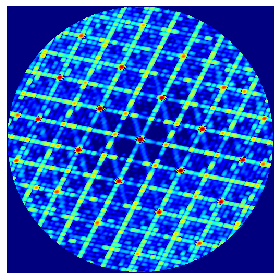

(57875,)


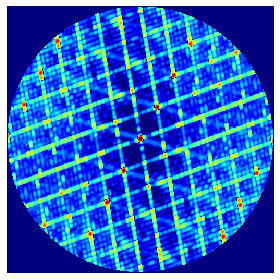

(57875,)


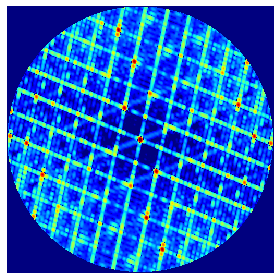

(57875,)


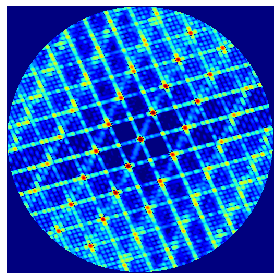

(57875,)


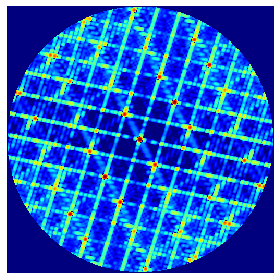

(57875,)


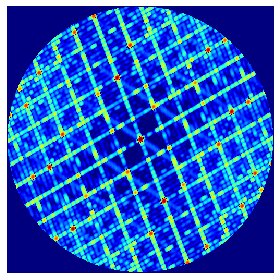

(57875,)


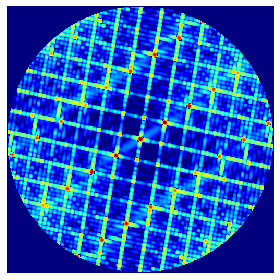

(57875,)


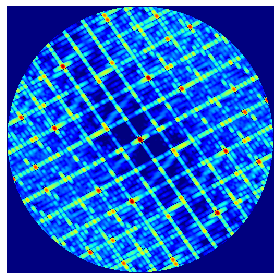

(57875,)


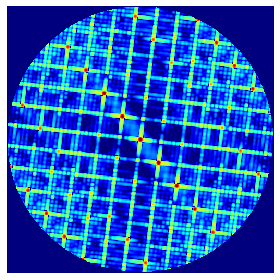

(57875,)


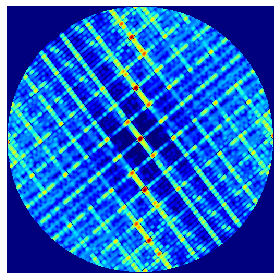

(57875,)


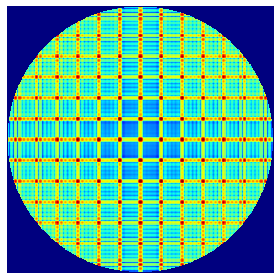

(57875,)


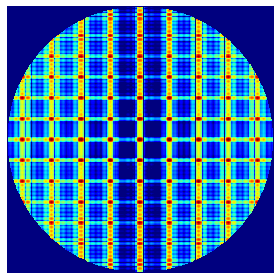

(57875,)


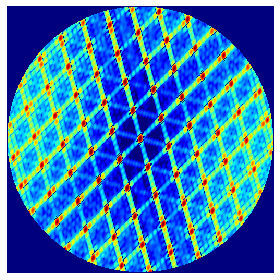

In [11]:
for mat in rotmats:
    dp = d.diffract(mat.T)
    idbig = d.circle_cutout(dp)
    print(idbig.shape)
    dp[np.unravel_index(idbig, (d.N, d.N))] = np.log10(d.bot)
    plt.imshow(dp, cmap = "jet")
    plt.axis("off")
    plt.show()